<img src='https://user-images.githubusercontent.com/6457691/90080969-0f758d00-dd47-11ea-8191-fa12fd2054a7.png' width = '200' align = 'right'>

## *DATA SCIENCE / SECTION 4 / SPRINT 3 / Assignment 4*

## 문제1.

아래는 Lecture Note에 있는 생성자 생성 함수입니다. Conv2DTranspose가 아닌 Upsampling을 사용하는 구조로 변경을 하였고, Seqeuntial API가 아닌 함수형 API를 사용하는 방식으로 변경을 하였습니다. 이때, Upsampling 층을 통과한 후의 이미지 shape에 대해 적어주세요.

Upsampling + Conv2D가 어떻게 Conv2DTranspose를 대체할 수 있는지, 각각의 역할이 무엇인지에 대해 찾아주세요!

- 문제1-1. 첫번째 Upsampling와 Conv2D 레이어를 통과한 후의 shape으로 알맞은 것은?
- 문제1-2. 첫번째 Conv2DTranspose 레이어르 통과한 후의 shape으로 알맞은 것은?

batch를 의미하는 None은 제외하고 [30, 30, 30] 형태로 적어주세요

In [12]:
import tensorflow as tf

In [13]:
def make_generator_model():
    generator_input = tf.keras.layers.Input(shape=(100,), name='generator_input')
    x = generator_input
    x = tf.keras.layers.Dense(7*7*256, use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Reshape((7,7,256))(x)
    
    x = tf.keras.layers.UpSampling2D()(x)
    x = tf.keras.layers.Conv2D(128, 5, strides=1, padding='same', use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU()(x)
    
    x = tf.keras.layers.UpSampling2D()(x)
    x = tf.keras.layers.Conv2D(64, 5, strides=1, padding='same', use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU()(x)
    
    x = tf.keras.layers.Conv2DTranspose(64, 5, strides=1, padding='same', use_bias=False)(x)
    x = tf.keras.layers.Conv2DTranspose(1, 5, strides=1, padding='same', use_bias=False, activation='tanh')(x)
    generator_output = x
    return tf.keras.models.Model(generator_input, generator_output)

model = make_generator_model()
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 generator_input (InputLayer  [(None, 100)]            0         
 )                                                               
                                                                 
 dense_2 (Dense)             (None, 12544)             1254400   
                                                                 
 batch_normalization_3 (Batc  (None, 12544)            50176     
 hNormalization)                                                 
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 12544)             0         
                                                                 
 reshape_1 (Reshape)         (None, 7, 7, 256)         0         
                                                                 
 up_sampling2d_2 (UpSampling  (None, 14, 14, 256)      0   

## 문제2
AutoEncoder에서 사용했던 구글 QuickDraw 데이터셋을 다시 활용해보겠습니다.

In [14]:
import json, glob, imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import time

from IPython import display

from tensorflow.keras import layers
from tensorflow.keras.utils import get_file

In [15]:
BASE_PATH = 'https://storage.googleapis.com/quickdraw_dataset/full/binary/'
path = get_file('cat', BASE_PATH + 'cat.bin')

19587072/19571324 [==============================] - 0s 0us/step


In [16]:
import PIL
from PIL import ImageDraw
from struct import unpack
from sklearn.model_selection import train_test_split

def load_drows(path, train_size=0.85):
    x = []
    # 파일을 풀고 낙서를 하나하나 모은다. 낙서는 15바이트 헤더로 시작한다.
    with open(path, 'rb') as f:
        while True:
            img = PIL.Image.new('L', (32, 32), 'white') # 8-bit pixels, black and white #https://pillow.readthedocs.io/en/stable/handbook/concepts.html#concept-modes
            draw = ImageDraw.Draw(img)
            header = f.read(15)
            if len(header) != 15:
                break
            # 낙서는 x,y 좌표로 구성된 획(stroke) 목록으로 되어 있고, 각 좌표는 분리되어 저장되어 있다.
            # 방금 위에서 생성한 ImageDraw 객체의 좌표 목록을 이용하기 위해 zip()함수를 사용하여 합쳐준다.
            strokes, = unpack('H', f.read(2))
            for i in range(strokes):
                n_points, = unpack('H', f.read(2))
                fmt = str(n_points) + 'B'
                read_scaled = lambda: (p // 8 for 
                                       p in unpack(fmt, f.read(n_points)))
                points = [*zip(read_scaled(), read_scaled())]               # zip 함수
                draw.line(points, fill=0, width=2)
            img = tf.keras.utils.img_to_array(img)
            x.append(img)
    x = np.asarray(x) / 255
    return train_test_split(x, train_size=train_size)

# 입력받은 10만개의 고양이 낙서 데이터를 활용할 수 있다. 
x_train, x_test = load_drows(path)
print(x_train.shape, x_test.shape) # ((104721, 32, 32, 1), (18481, 32, 32, 1))

(104721, 32, 32, 1) (18481, 32, 32, 1)


오늘 학습한 기본적인 GAN을 활용하여 고양이 그림을 그려내는 여러분만의 GAN을 만들어보세요!

1 EPOCH가 끝날 때마다, 생성자가 그림을 어떻게 생성해내는지 ```generator_and_save_images```를 통해 확인할 수 있었는데요. 이번 과제에서도 GAN의 학습이 제대로 이루어지고 있는지 확인해보세요

다음과 같은 내용을 숙지하며 과제를 진행해주세요.
1. 입력 이미지 shape이 변했을 때, 어느 부분을 수정해야 하는가
2. MNIST를 학습하는데 사용했던 EPOCH 수가 해당 데이터셋에서 생성자가 고양이 그림을 생성해내는데 충분한가

아래는 38 epoch까지 수행했을 때, 생성자가 만들어내는 이미지입니다.

In [17]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import time

In [18]:
def build_generator_model(): ## 생성자
    generator_input = tf.keras.layers.Input(shape=(100,), name='generator_input')
    x = generator_input
    x = tf.keras.layers.Dense(8*8*256, use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Reshape((8,8,256))(x)
    
    x = tf.keras.layers.UpSampling2D()(x)
    x = tf.keras.layers.Conv2D(128, 5, strides=1, padding='same', use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU()(x)
    
    x = tf.keras.layers.UpSampling2D()(x)
    x = tf.keras.layers.Conv2D(64, 5, strides=1, padding='same', use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU()(x)
    
    x = tf.keras.layers.Conv2DTranspose(64, 5, strides=1, padding='same', use_bias=False)(x)
    x = tf.keras.layers.Conv2DTranspose(1, 5, strides=1, padding='same', use_bias=False, activation='tanh')(x)
    generator_output = x
    return tf.keras.models.Model(generator_input, generator_output)

generator = build_generator_model()
generator.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 generator_input (InputLayer  [(None, 100)]            0         
 )                                                               
                                                                 
 dense_3 (Dense)             (None, 16384)             1638400   
                                                                 
 batch_normalization_6 (Batc  (None, 16384)            65536     
 hNormalization)                                                 
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 16384)             0         
                                                                 
 reshape_2 (Reshape)         (None, 8, 8, 256)         0         
                                                                 
 up_sampling2d_4 (UpSampling  (None, 16, 16, 256)      0   

In [19]:
def build_discriminator_model():  ## 판별자
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 1]))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.3))

    model.add(tf.keras.layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.3))

    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(1))

    return model

discriminator = build_discriminator_model()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 16, 16, 64)        1664      
                                                                 
 leaky_re_lu_11 (LeakyReLU)  (None, 16, 16, 64)        0         
                                                                 
 dropout_2 (Dropout)         (None, 16, 16, 64)        0         
                                                                 
 conv2d_9 (Conv2D)           (None, 8, 8, 128)         204928    
                                                                 
 leaky_re_lu_12 (LeakyReLU)  (None, 8, 8, 128)         0         
                                                                 
 dropout_3 (Dropout)         (None, 8, 8, 128)         0         
                                                                 
 flatten_1 (Flatten)         (None, 8192)             

In [20]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [21]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [22]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16
BATCH_SIZE = 256

seed = tf.random.normal([num_examples_to_generate, noise_dim])

@tf.function
def train_step(images):
    """
    위에서 정의한 손실함수를 바탕으로
    Iteration(=step) 마다 가중치를 갱신합니다.

    Args:
        images: 훈련 데이터셋에 있는 실제 이미지입니다.
    """
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [23]:
def generate_and_save_images(model, epoch, test_input):
    """
    모델이 이미지를 생성한 후 저장하는 함수입니다.
    
    Args:
        model: 이미지를 생성할 모델입니다.
        epoch: 진행 중인 Epoch 숫자입니다.
        test_input: model에 입력되는 데이터입니다.
    """

    # training=False 이면 모든 층이 추론(inference)모드로 진행됩니다.
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4,4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

In [24]:
def train(dataset, epochs, batch_size=67):
    """
    학습 중 실행할 동작을 함수로 정의합니다.
    
    Args:
        dataset: (훈련) 데이터셋입니다.
        epochs: 최종 학습 Epoch 입니다.
    """
    for epoch in range(epochs):
        start = time.time()

        for pivot in range(0, dataset.shape[0], batch_size):
            next = pivot + batch_size
            train_step(dataset[pivot:next])

        # 이미지를 생성한 뒤 저장합니다.(추후에 만들 GIF를 위함입니다.)
        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch + 1, seed)

        # 15 에포크가 지날 때마다 모델을 Checkpoint에 저장합니다.
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)
        
        # Epoch 마다 소요 시간을 출력합니다.
        print(f'Time for epoch {epoch + 1} is {time.time()-start} sec')

    # 마지막 에포크가 끝난 후 이미지를 생성합니다.
    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)

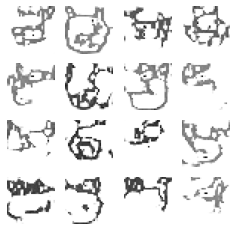

Time for epoch 13 is 192.11414742469788 sec


In [ ]:
%%time
train(x_train, 38)